# Deep learning

## Assignment 3

Previously in _2_fullyconnected.ipynb_, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [91]:

from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle


In [92]:
%matplotlib inline
from matplotlib import pyplot as plt

First reload the data we generated in notmnist.ipynb

In [93]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [94]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [95]:
def accuracy(predictions, labels):
    return(100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

## Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

___
[_tf.Variable vs tf.placeholder_](http://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable)

___

In [96]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    # Input data 
    # For the training data, we use a placeholder that will be fed
    # at runtime with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases  
    # Original loss function 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Loss function with L2 regularization
    regularizer = tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(loss + beta_regul * regularizer)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    #Predictions for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [97]:
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: 0.002}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        if(step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
        


Initialized
Minibatch loss at step 0: 26.252684
Minibatch accuracy: 5.5%
Validation accuracy: 12.3%
Minibatch loss at step 500: 2.841987
Minibatch accuracy: 77.3%
Validation accuracy: 76.9%
Minibatch loss at step 1000: 1.426391
Minibatch accuracy: 78.1%
Validation accuracy: 79.6%
Minibatch loss at step 1500: 0.681517
Minibatch accuracy: 84.4%
Validation accuracy: 81.2%
Minibatch loss at step 2000: 0.637056
Minibatch accuracy: 89.1%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 0.725769
Minibatch accuracy: 81.2%
Validation accuracy: 81.8%
Minibatch loss at step 3000: 0.714506
Minibatch accuracy: 83.6%
Validation accuracy: 81.9%
Test accuracy: 89.1%


___
played with beta_regul, and this is the maximum accuracy I got. Values used were (0.1, 0.01, 0.001, 0.0001. 0.002, 0.005)
___

Neural network with L2 regularization
* 1 hidden layer using RELUs

In [98]:
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computatiuon.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_2, tf_train_labels))
    # Loss function with L2 regularization with beta = 0.01
    regularizer = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta_regul * regularizer)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)   ## relu(logits for validation)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    test_prediction = tf.nn.softmax(logits_2)



In [99]:
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.01}
        _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        

Initialized
Minibatch loss at step 0: 3574.536621
Minibatch accuracy: 17.2%
Validation accuracy: 33.2%
Minibatch loss at step 500: 21.220131
Minibatch accuracy: 86.7%
Validation accuracy: 84.2%
Minibatch loss at step 1000: 0.949872
Minibatch accuracy: 82.0%
Validation accuracy: 83.0%
Minibatch loss at step 1500: 0.583126
Minibatch accuracy: 85.9%
Validation accuracy: 83.5%
Minibatch loss at step 2000: 0.608697
Minibatch accuracy: 90.6%
Validation accuracy: 83.4%
Minibatch loss at step 2500: 0.707500
Minibatch accuracy: 85.2%
Validation accuracy: 83.3%
Minibatch loss at step 3000: 0.765101
Minibatch accuracy: 82.8%
Validation accuracy: 83.4%
Test accuracy: 90.3%


In [55]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for val in regul_val:
    
    with tf.Session(graph = graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.        
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = train_dataset[offset: (offset + batch_size), :]
            batch_labels = train_labels[offset: (offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : val}
            _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        


Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


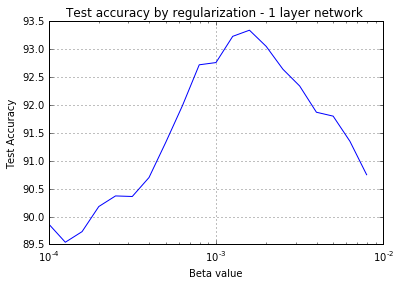

In [65]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.xlabel('Beta value')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy by regularization - 1 layer network ')
plt.show()

## Problem 2

Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?


In [100]:
num_steps = 51
num_batches = 5

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.        
        offset = step  % num_batches
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.01}
        _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        if (step % 5 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3485.411377
Minibatch accuracy: 12.5%
Validation accuracy: 30.1%
Minibatch loss at step 5: 3036.919434
Minibatch accuracy: 87.5%
Validation accuracy: 59.4%
Minibatch loss at step 10: 2860.833496
Minibatch accuracy: 96.1%
Validation accuracy: 62.9%
Minibatch loss at step 15: 2708.144043
Minibatch accuracy: 100.0%
Validation accuracy: 62.9%
Minibatch loss at step 20: 2575.739990
Minibatch accuracy: 100.0%
Validation accuracy: 62.9%
Minibatch loss at step 25: 2449.811768
Minibatch accuracy: 100.0%
Validation accuracy: 62.9%
Minibatch loss at step 30: 2330.041992
Minibatch accuracy: 100.0%
Validation accuracy: 62.8%
Minibatch loss at step 35: 2216.125732
Minibatch accuracy: 100.0%
Validation accuracy: 62.8%
Minibatch loss at step 40: 2107.777344
Minibatch accuracy: 100.0%
Validation accuracy: 62.8%
Minibatch loss at step 45: 2004.732178
Minibatch accuracy: 100.0%
Validation accuracy: 62.8%
Minibatch loss at step 50: 1906.717896
Minibatch accuracy: 100.

## Problem 3

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

In [101]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computatiuon.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)
    # Dropout on hidden RELU layer
    keep_prob = tf.placeholder(tf.float32)
    relu_layer_dropout = tf.nn.dropout(relu_layer, keep_prob)
    
    logits_2 = tf.matmul(relu_layer_dropout, weights_2) + biases_2
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_2, tf_train_labels))
    # Loss function with L2 regularization with beta = 0.01
    regularizer = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean(loss + beta_regul * regularizer)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)   ## relu(logits for validation)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    test_prediction = tf.nn.softmax(logits_2)

In [102]:
num_steps = 3001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.01, keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3643.201660
Minibatch accuracy: 9.4%
Validation accuracy: 25.2%
Minibatch loss at step 500: 21.408806
Minibatch accuracy: 82.8%
Validation accuracy: 83.8%
Minibatch loss at step 1000: 0.981625
Minibatch accuracy: 80.5%
Validation accuracy: 82.8%
Minibatch loss at step 1500: 0.647521
Minibatch accuracy: 85.2%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 0.670097
Minibatch accuracy: 89.8%
Validation accuracy: 82.9%
Minibatch loss at step 2500: 0.796062
Minibatch accuracy: 85.2%
Validation accuracy: 82.9%
Minibatch loss at step 3000: 0.836442
Minibatch accuracy: 82.8%
Validation accuracy: 83.3%
Test accuracy: 89.9%


***Overfitting case***

In [103]:
num_steps = 51
num_batches = 5

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.        
        offset = step  % num_batches
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.01, keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        if (step % 5 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3630.444580
Minibatch accuracy: 5.5%
Validation accuracy: 27.5%
Minibatch loss at step 5: 3283.496094
Minibatch accuracy: 66.4%
Validation accuracy: 62.0%
Minibatch loss at step 10: 2887.829346
Minibatch accuracy: 92.2%
Validation accuracy: 63.8%
Minibatch loss at step 15: 2719.365479
Minibatch accuracy: 98.4%
Validation accuracy: 67.3%
Minibatch loss at step 20: 2585.655273
Minibatch accuracy: 95.3%
Validation accuracy: 63.8%
Minibatch loss at step 25: 2459.254395
Minibatch accuracy: 99.2%
Validation accuracy: 67.1%
Minibatch loss at step 30: 2341.711914
Minibatch accuracy: 97.7%
Validation accuracy: 67.5%
Minibatch loss at step 35: 2224.868896
Minibatch accuracy: 99.2%
Validation accuracy: 68.2%
Minibatch loss at step 40: 2115.009277
Minibatch accuracy: 99.2%
Validation accuracy: 66.9%
Minibatch loss at step 45: 2021.125854
Minibatch accuracy: 96.9%
Validation accuracy: 67.8%
Minibatch loss at step 50: 1913.511719
Minibatch accuracy: 100.0%
Valid

Test accuracy increased from 69.7% to 74.6% using dropout technique

## Probelm 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595)

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:


    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


In [146]:
* Six layer neural network

SyntaxError: invalid syntax (<ipython-input-146-013baaf4bdaa>, line 1)

In [141]:
import numpy as np
batch_size = 128
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 512
num_hidden_nodes_3 = 256
num_hidden_nodes_4 = 128
num_hidden_nodes_5 = 64
num_hidden_nodes_6 = 32

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)
    
    # Variables.
    # Hidden RELU layer1
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes_1], 
                            stddev = np.sqrt(2.0 / (image_size * image_size) )))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))
    
    # Hidden RELU layer2    
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_1 )))
    biases_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    
    # Hidden RELU layer3    
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_2 )))
    biases_3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))
    
    # Hidden RELU layer4    
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_nodes_3, num_hidden_nodes_4], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_3 )))
    biases_4 = tf.Variable(tf.zeros([num_hidden_nodes_4]))
    
    # Hidden RELU layer5    
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_nodes_4, num_hidden_nodes_5], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_4 )))
    biases_5 = tf.Variable(tf.zeros([num_hidden_nodes_5]))
    
    # Hidden RELU layer6
    weights_6 = tf.Variable(tf.truncated_normal([num_hidden_nodes_5, num_hidden_nodes_6], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_5 )))
    biases_6 = tf.Variable(tf.zeros([num_hidden_nodes_6]))
    
    # Output layer
    weights_7 = tf.Variable(tf.truncated_normal([num_hidden_nodes_6, num_labels], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_6 )))
    biases_7 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation.
    
    # Hidden RELU layer 1
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer_1 = tf.nn.relu(logits_1)
    # Dropout on hidden RELU layer 1    
    relu_layer_1_dropout = tf.nn.dropout(relu_layer_1, keep_prob)
    
    # Hidden RELU layer 2
    logits_2 = tf.matmul(relu_layer_1_dropout, weights_2) + biases_2
    relu_layer_2 = tf.nn.relu(logits_2)
    # Dropout on hidden RELU layer 2
    relu_layer_2_dropout = tf.nn.dropout(relu_layer_2, keep_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(relu_layer_2_dropout, weights_3) + biases_3
    relu_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden RELU layer 3
    relu_layer_3_dropout = tf.nn.dropout(relu_layer_3, keep_prob)
    
    # Hidden RELU layer 4
    logits_4 = tf.matmul(relu_layer_3_dropout, weights_4) + biases_4
    relu_layer_4 = tf.nn.relu(logits_4)
    # Dropout on hidden RELU layer 4
    relu_layer_4_dropout = tf.nn.dropout(relu_layer_4, keep_prob)
    
    # Hidden RELU layer 5
    logits_5 = tf.matmul(relu_layer_4_dropout, weights_5) + biases_5
    relu_layer_5 = tf.nn.relu(logits_5)
    # Dropout on hidden RELU layer 5
    relu_layer_5_dropout = tf.nn.dropout(relu_layer_5, keep_prob)
    
    # Hidden RELU layer 6
    logits_6 = tf.matmul(relu_layer_5_dropout, weights_6) + biases_6
    relu_layer_6 = tf.nn.relu(logits_6)
    # Dropout on hidden RELU layer 6
    relu_layer_6_dropout = tf.nn.dropout(relu_layer_6, keep_prob)
    
    # Output layer
    logits_7 = tf.matmul(relu_layer_6_dropout, weights_7) + biases_7
    
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_7, tf_train_labels))
    # Loss function with L2 regularization with beta = 0.01
    regularizer = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4) + tf.nn.l2_loss(weights_5) + tf.nn.l2_loss(weights_6) + tf.nn.l2_loss(weights_7)
    loss = tf.reduce_mean(loss + beta_regul * regularizer)
    
    # Optimizer
    # Learning rate decay
    global_step = tf.Variable(0)
    learning_rate_decay = tf.train.exponential_decay(0.5, global_step, decay_steps = 2000, decay_rate = 0.7, staircase=False)    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate_decay).minimize(loss, global_step = global_step)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_7)
    
    # Predictions for validation
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_layer_1 = tf.nn.relu(valid_logits_1)  
                              
    valid_logits_2 = tf.matmul(valid_relu_layer_1, weights_2) + biases_2
    valid_relu_layer_2 = tf.nn.relu(valid_logits_2) 
    
    valid_logits_3 = tf.matmul(valid_relu_layer_2, weights_3) + biases_3
    valid_relu_layer_3 = tf.nn.relu(valid_logits_3) 
    
    valid_logits_4 = tf.matmul(valid_relu_layer_3, weights_4) + biases_4
    valid_relu_layer_4 = tf.nn.relu(valid_logits_4)
                
    valid_logits_5 = tf.matmul(valid_relu_layer_4, weights_5) + biases_5
    valid_relu_layer_5 = tf.nn.relu(valid_logits_5)
                              
    valid_logits_6 = tf.matmul(valid_relu_layer_5, weights_6) + biases_6
    valid_relu_layer_6 = tf.nn.relu(valid_logits_6)
                              
    valid_logits_7 = tf.matmul(valid_relu_layer_6, weights_7) + biases_7
                            
    valid_prediction = tf.nn.softmax(valid_logits_7)
    
    # Predictions for test
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_layer_1 = tf.nn.relu(test_logits_1)
                              
    test_logits_2 = tf.matmul(test_relu_layer_1, weights_2) + biases_2
    test_relu_layer_2 = tf.nn.relu(test_logits_2)
                              
    test_logits_3 = tf.matmul(test_relu_layer_2, weights_3) + biases_3
    test_relu_layer_3 = tf.nn.relu(test_logits_3)
                              
    test_logits_4 = tf.matmul(test_relu_layer_3, weights_4) + biases_4
    test_relu_layer_4 = tf.nn.relu(test_logits_4)                          
                              
    test_logits_5 = tf.matmul(test_relu_layer_4, weights_5) + biases_5
    test_relu_layer_5 = tf.nn.relu(test_logits_5)
                              
    test_logits_6 = tf.matmul(test_relu_layer_5, weights_6) + biases_6
    test_relu_layer_6 = tf.nn.relu(test_logits_6)
                            
    test_logits_7 = tf.matmul(test_relu_layer_6, weights_7) + biases_7                    
    test_prediction = tf.nn.softmax(test_logits_7)

In [142]:
num_steps = 10001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.002, keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 6.735542
Minibatch accuracy: 13.3%
Validation accuracy: 10.0%
Minibatch loss at step 500: 2.523684
Minibatch accuracy: 61.7%
Validation accuracy: 70.0%
Minibatch loss at step 1000: 1.581709
Minibatch accuracy: 75.0%
Validation accuracy: 80.3%
Minibatch loss at step 1500: 1.220727
Minibatch accuracy: 79.7%
Validation accuracy: 82.6%
Minibatch loss at step 2000: 1.054976
Minibatch accuracy: 79.7%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 1.193612
Minibatch accuracy: 77.3%
Validation accuracy: 83.9%
Minibatch loss at step 3000: 0.989938
Minibatch accuracy: 80.5%
Validation accuracy: 84.3%
Minibatch loss at step 3500: 1.135476
Minibatch accuracy: 72.7%
Validation accuracy: 84.4%
Minibatch loss at step 4000: 0.936819
Minibatch accuracy: 82.8%
Validation accuracy: 85.1%
Minibatch loss at step 4500: 0.858222
Minibatch accuracy: 83.6%
Validation accuracy: 85.1%
Minibatch loss at step 5000: 0.799262
Minibatch accuracy: 84.4%
Validation accurac

num_steps = 10001, beta_regul : 0.008, decay_steps = 2000, decay_rate = 0.75, staircase=**False**,  test_accuracy = 91.2%

num_steps = 10001, beta_regul : 0.008, decay_steps = 2000, decay_rate = 0.75, staircase=True,  test_accuracy = 90.8%

num_steps = 10001, beta_regul : 0.008, decay_steps = 2000, decay_rate = **0.5**, staircase=True,  test_accuracy = 91.6%

num_steps = 10001, beta_regul : 0.008, decay_steps = 2000, decay_rate = 0.5, staircase=**False**,  test_accuracy = 91.9%

num_steps = 10001, beta_regul : **0.002**, decay_steps = 2000, decay_rate = 0.5, staircase=False,  test_accuracy = 94.2%

num_steps = 10001, beta_regul : 0.002, decay_steps = **5000**, decay_rate = 0.5, staircase=False,  test_accuracy = 92.9%

num_steps = 10001, beta_regul : 0.002, decay_steps = **1000**, decay_rate = 0.5, staircase=False,  test_accuracy = 92.8%

num_steps = 10001, beta_regul : 0.002, decay_steps = 2000, decay_rate = **0.1**, staircase=False,  test_accuracy = 91.1%

num_steps = 10001, beta_regul : 0.002, decay_steps = 2000, decay_rate = **0.4**, staircase=False,  test_accuracy = 93.8%

num_steps = 10001, beta_regul : 0.002, decay_steps = 2000, decay_rate = **0.6**, staircase=False,  test_accuracy = 94.1%

num_steps = 10001, beta_regul : 0.002, decay_steps = 2000, decay_rate = 0.6, staircase=False,  test_accuracy = 92% **(dropout-> 0.5 to 0.4) Only in this case, I changed the dropout value**

num_steps = 10001, beta_regul : 0.002, decay_steps = 2000, decay_rate = **0.7**, staircase=False,  test_accuracy = 93.5%

num_steps = 10001, beta_regul : **0.001**, decay_steps = 2000, decay_rate = **0.5**, staircase=False,  test_accuracy = 93.5%

* Three layer neural network

In [147]:
import numpy as np
batch_size = 128
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 512
num_hidden_nodes_3 = 256

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)
    
    # Variables.
    # Hidden RELU layer1
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes_1], 
                            stddev = np.sqrt(2.0 / (image_size * image_size) )))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))
    
    # Hidden RELU layer2    
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_1 )))
    biases_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
    
    # Hidden RELU layer3    
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_2 )))
    biases_3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))    
    
    # Output layer
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_nodes_3, num_labels], 
                            stddev = np.sqrt(2.0 / num_hidden_nodes_3 )))
    biases_4 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation.
    
    # Hidden RELU layer 1
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer_1 = tf.nn.relu(logits_1)
    # Dropout on hidden RELU layer 1    
    relu_layer_1_dropout = tf.nn.dropout(relu_layer_1, keep_prob)
    
    # Hidden RELU layer 2
    logits_2 = tf.matmul(relu_layer_1_dropout, weights_2) + biases_2
    relu_layer_2 = tf.nn.relu(logits_2)
    # Dropout on hidden RELU layer 2
    relu_layer_2_dropout = tf.nn.dropout(relu_layer_2, keep_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(relu_layer_2_dropout, weights_3) + biases_3
    relu_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden RELU layer 3
    relu_layer_3_dropout = tf.nn.dropout(relu_layer_3, keep_prob)
        
    # Output layer
    logits_4 = tf.matmul(relu_layer_3_dropout, weights_4) + biases_4
    
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_4, tf_train_labels))
    # Loss function with L2 regularization with beta = 0.01
    regularizer = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4)
    loss = tf.reduce_mean(loss + beta_regul * regularizer)
    
    # Optimizer
    # Learning rate decay
    global_step = tf.Variable(0)
    learning_rate_decay = tf.train.exponential_decay(0.5, global_step, decay_steps = 2000, decay_rate = 0.7, staircase=False)    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate_decay).minimize(loss, global_step = global_step)
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_4)
    
    # Predictions for validation
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_layer_1 = tf.nn.relu(valid_logits_1)  
                              
    valid_logits_2 = tf.matmul(valid_relu_layer_1, weights_2) + biases_2
    valid_relu_layer_2 = tf.nn.relu(valid_logits_2) 
    
    valid_logits_3 = tf.matmul(valid_relu_layer_2, weights_3) + biases_3
    valid_relu_layer_3 = tf.nn.relu(valid_logits_3) 
                              
    valid_logits_4 = tf.matmul(valid_relu_layer_3, weights_4) + biases_4
                            
    valid_prediction = tf.nn.softmax(valid_logits_4)
    
    # Predictions for test
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_layer_1 = tf.nn.relu(test_logits_1)
                              
    test_logits_2 = tf.matmul(test_relu_layer_1, weights_2) + biases_2
    test_relu_layer_2 = tf.nn.relu(test_logits_2)
                              
    test_logits_3 = tf.matmul(test_relu_layer_2, weights_3) + biases_3
    test_relu_layer_3 = tf.nn.relu(test_logits_3)
                                                          
    test_logits_4 = tf.matmul(test_relu_layer_3, weights_4) + biases_4                    
    test_prediction = tf.nn.softmax(test_logits_4)

In [149]:
num_steps = 20001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.0008, keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss , train_prediction], feed_dict = feed_dict)
        if (step % 2000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.800890
Minibatch accuracy: 8.6%
Validation accuracy: 23.4%
Minibatch loss at step 2000: 0.808674
Minibatch accuracy: 91.4%
Validation accuracy: 86.5%
Minibatch loss at step 4000: 0.664694
Minibatch accuracy: 86.7%
Validation accuracy: 88.0%
Minibatch loss at step 6000: 0.744175
Minibatch accuracy: 85.2%
Validation accuracy: 89.0%
Minibatch loss at step 8000: 0.781964
Minibatch accuracy: 80.5%
Validation accuracy: 89.2%
Minibatch loss at step 10000: 0.627172
Minibatch accuracy: 86.7%
Validation accuracy: 89.4%
Minibatch loss at step 12000: 0.650149
Minibatch accuracy: 85.2%
Validation accuracy: 89.5%
Minibatch loss at step 14000: 0.574272
Minibatch accuracy: 85.9%
Validation accuracy: 89.5%
Minibatch loss at step 16000: 0.500522
Minibatch accuracy: 90.6%
Validation accuracy: 89.5%
Minibatch loss at step 18000: 0.469455
Minibatch accuracy: 93.0%
Validation accuracy: 89.6%
Minibatch loss at step 20000: 0.636374
Minibatch accuracy: 86.7%
Validation a

num_steps = 10001, beta_regul : 0.002, decay_steps = 2000, decay_rate = 0.7, staircase=False,  test_accuracy = 94.6%

num_steps = **20001**, beta_regul : 0.002, decay_steps = 2000, decay_rate = 0.7, staircase=False,  test_accuracy = 95.3%

num_steps = 20001, beta_regul : 0.002, decay_steps = 2000, decay_rate = **0.5**, staircase=False,  test_accuracy = 95.0%

num_steps = 20001, beta_regul : **0.0008**, decay_steps = 2000, decay_rate = **0.7**, staircase=False, test_accuracy = 95.3%

